In [999]:
import numpy as np
from scipy import stats
from scipy import interpolate

from PIL import Image

from matplotlib import pyplot as plt

import glob,os

In [1000]:
def preprocesing_images(path_="dataset"):
    """
    getting file names of all images from folder 'path_'
    Arguments:
    path_ -- path to folder with dataset, default value='dataset'

    Return:
    files -- list of file names
    """
    path_="dataset/*/*.pgm"
    files=glob.glob(path_)
    return files

photo size: (112, 92)
Image sample:


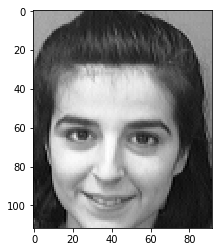

In [1001]:
#getting file names of all images in folder "dataset"
files= preprocesing_images(path_="dataset")
sample=files[10]
img=np.array(Image.open(sample))
print(f'photo size: {img.shape}')
print('Image sample:')
plt.imshow(img, cmap='gray')

In [1002]:
# set parametrs for model
rows=len(files)
HEIGHT=img.shape[0]
WIDTH=img.shape[1]
columns=HEIGHT*WIDTH

In [1003]:
def create_data_matrix(files,rows,columns):
    """
    This method vectorizes images and creates matrix with shape (rows,columns).
    Where 'rows' - number of images and 'columns' - number of features (features=image height * image width)
    
    Arguments:
    files -- list of file names
    rows -- number of images
    columns -- number of features
    
    """
    row=0
    labels=[]
    data=np.zeros((rows,columns))
    for f in files:
        im=np.array(Image.open(f))
        im=im.reshape(1,im.shape[0]*im.shape[1])
   
        #create dataset: "data"
        data[row,:]=im
        row+=1
   
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [1004]:
#creating dataset from images: data and labels
data, labels = create_data_matrix(files,rows,columns)
print(f'Dataset shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Dataset shape: (400, 10304)
Labels shape: (400, 1)


In [1005]:
def vec_to_image(v,w=(HEIGHT,WIDTH)):
    """
    Convert image vector into image array
    
    Arguments:
    v -- image vector
    w -- array size for reshaping [height, width]
    
    Return:
    img -- converted vector into array
    
    """
    img=v.reshape(w[0],w[1])
    return img

def show_image(ind,data,labels,size=(HEIGHT,WIDTH)):
    """
    Show image and label from dataset.
    
    Arguments:
    ind -- index of image in dataset
    data -- matrix of dataset
    labels -- labels of images from dataset
    size -- pixel size of image.
    """
    img=vec_to_image(data[ind],size)
    plt.imshow(img, cmap='gray')
    plt.title(f'label: {np.squeeze(labels)[ind]}')

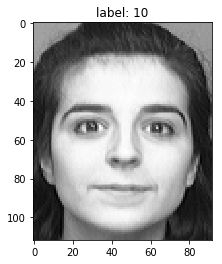

In [1006]:
#test, select and show photo with index=11
index=11
show_image(index,data,labels)

In [1007]:
def select_index(ind1, ind2):
    """
    selct ind1 and ind2 images from each employee
    Arguments:
    
    ind1 -- index first image for each employee
    ind2 -- index second image for each employee
    
    Return:
    test_index -- indices for test dataset, where we have 80 images (2 images for each employee * 40 employee)
    
    """
    ind1=ind1-1 #for correct indexing in array, where first element has index 0
    ind2=ind2-1
    ind1=[i+10 for i in range(ind1-10,390,10)]
    ind2=[i+10 for i in range(ind2-10,390,10)]
    test_index=np.concatenate((ind1,ind2))
    return test_index

In [1008]:
def split_dataset(data,ind1=9, ind2=10):
    """
    Split data to train and test.
    Arguments:
    data -- dataset matrix
    ind1, ind2 -- index for selection test dataset
    
    Return:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    
    """
    #create indices for test dataset
    index=select_index(ind1, ind2)
    
    #create test dataset
    test_set=data[index,:]
    test_labels=labels[index]
    
    #create train data_set
    train_set=np.delete(data,index,axis=0)
    train_labels=np.delete(labels,index)
    train_labels=train_labels.reshape(len(train_labels),1)
    
    return train_set, train_labels, test_set, test_labels 

In [1009]:
# split data to train and test
train_set, train_labels, test_set, test_labels = split_dataset(data)
print(f'Train set shape: {train_set.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_set.shape}, test labels shape: {test_labels.shape}')
train_orginal=train_set
test_original=test_set

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


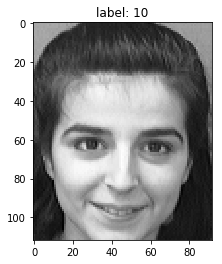

In [1010]:
show_image(10,train_set,train_labels)

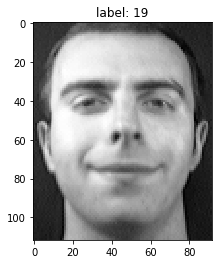

In [1011]:
show_image(10,test_set,test_labels)

In [1012]:
# load unknown photos and identify employee
def identify_employee(train_set,unknown_set,lbp_flag=False):
    """
    This method use MSE algorithm and identify employee.
    
    Arguments:
    train_set -- train dataset
    unknown_set -- vectorized photos that we have to recognize (test data set)
    lbp_flag -- if True, we use chi-square distance for identification
    
    Returns:
    predict_index -- vector of indices, that predict labels of test dataset images
    """
    if lbp_flag:
        train_set=standard_norm(train_set, axis=1)
        unknown_set=standard_norm(unknown_set, axis=1)
        print ('For LBT algorithm use only standardize data by samples (norm=2,axis=1)')
        predict_index=identify_employee_chi(train_set,unknown_set)
    else:
        min_dist=[]
        for ind in range(unknown_set.shape[0]):
            dist=np.linalg.norm(train_set-unknown_set[ind,:],axis=1,keepdims=True)
            min_dist.append(np.argmin(dist))
        predict_index=np.array(min_dist).reshape(len(min_dist),1)
    return predict_index

def accuracy(train_labels,test_labels, predict_index, index=1):
    """
    Calculate accuracy.
    
    Arguments:
    train_label -- labels for train dataset
    test_labels -- labels for test dataset
    predict_index -- vector of indices, that predict labels of test dataset images
    index -- it uses for distinguishing usual algorithm and PCA, where accuracy receives labels insted of index
    
    Returns:
    acc -- accuracy
    err_index -- error indices
    true_index -- true indices
    """
    if index:
        yhat=np.squeeze(train_labels[predict_index])
    else:
        yhat=predict_index
    ytest=np.squeeze(test_labels)
    compare=yhat==ytest
    err_index=np.where(compare==False)
    true_index=np.where(compare==True)
    true_answ=sum(compare)
    acc = (true_answ/test_labels.shape[0])*100     
    return acc,err_index,true_index

def show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,figsize=(10,10),index=1,
                X=train_orginal,X_test=test_original):
    """
    This additional method that helps to display errors of recognition or true answers of model.
    """
    n=1
    if len(err_index[0])<=1:
        l=1
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        plt.subplot(l,2,n)
        if index==True:
            show_image(predict_index[err_index],train_set,train_labels)
        else:
            show_image(np.where(train_labels==predict_index[err_index])[0][0],train_set,train_labels)
        n+=1
        plt.subplot(l,2,n)
        show_image(err_index,test_set,test_labels)  
    else:
        err_index=np.squeeze(err_index)
        l=err_index.shape[0]
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        for i in err_index:
            plt.subplot(l,2,n)
            if index==1:
                show_image(predict_index[i],train_set,train_labels)
            elif index==2:
                show_image(np.where(train_labels==predict_index[i])[0][0],train_set,train_labels)
            elif index==3:
                show_image(predict_index[i],X,train_labels)
                           
            n+=1
            plt.subplot(l,2,n)
            if index==3:
                show_image(i,X_test,test_labels)
            else:
                show_image(i,test_set,test_labels)
            n+=1

In [1013]:
def model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=True,show_correct=False,figsize=(10,10), index=1, norm=0, axis=0,
                           pca_flag=False, pca_energy=0.98,log=True, lbp_flag=False,n_split=1,R=1,interpolation=False):
    
    """
    This function recognise face.
    
    Arguments:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    show_err -- flag for showing recognation errors, default value = True
    show_correct -- flag for showing samples of corect recognition, default value = False
    figsize -- figsize for displaying errors ot true answers
    index -- type of image processing for method show_erros, default value=1
    norm -- type of normalization. 1 - substract mean, 2 - standardize data, 0 - without normalization
    axis -- axis of normalization
    pca_flag -- turn on PCA
    pca_energy -- coefficient of explained bariance, default value=0.98
    log -- turn on print log
    lbp_flag -- turn on LBP
    n_split -- the number of blocks(divide the images into n*n blocks)
    R -- The radius of the circle, which allows us to account for different scales
    interpolation -- turn on (True) / off (False) interpolation
      
    Return:
    acc -- Accuracy
    """
    
    #Normalization
    if not (lbp_flag): 
        
        if norm==1:
            train_set=subtract_mean(train_set, axis=axis)
            test_set=subtract_mean(test_set, axis=axis)
        elif norm==2:
            train_set=standard_norm(train_set, axis=axis)
            test_set=standard_norm(test_set, axis=axis)

        if pca_flag :
            if norm==0:
                print('Warning! You have to make normalization.') 
            train_set,transform_pca = my_pca(train_set,pca_energy=pca_energy,log=log)
            test_set = np.dot(transform_pca,test_set.T).T
        
    if lbp_flag:
        train_set=create_lbp_set_2(train_set,R=R,n_split=n_split,height=HEIGHT,width=WIDTH,interpolation=interpolation)
        test_set=create_lbp_set_2(test_set,R=R,n_split=n_split,height=HEIGHT,width=WIDTH,interpolation=interpolation)
        if pca_flag:
            train_set,transform_pca = my_pca(train_set,pca_energy=pca_energy,log=log)
            test_set = np.dot(transform_pca,test_set.T).T
               
    predict_index=identify_employee(train_set,test_set,lbp_flag)
    
    acc,err_index,true_index=accuracy(train_labels,test_labels, predict_index,index=index)
    if log:
        print(f'Accuracy for test dataset = {acc}')
    #Error visualization
    if show_err:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,index=index,figsize=figsize)
    if show_correct:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,true_index,index=index,figsize=(10,90))
    return acc

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

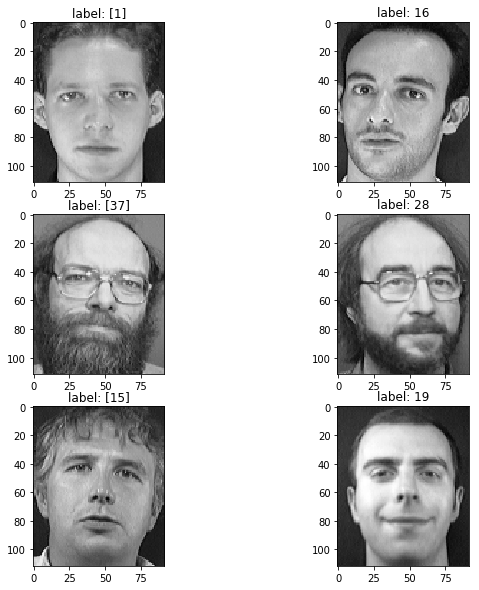

In [1014]:
# Result without normalization
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True)

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

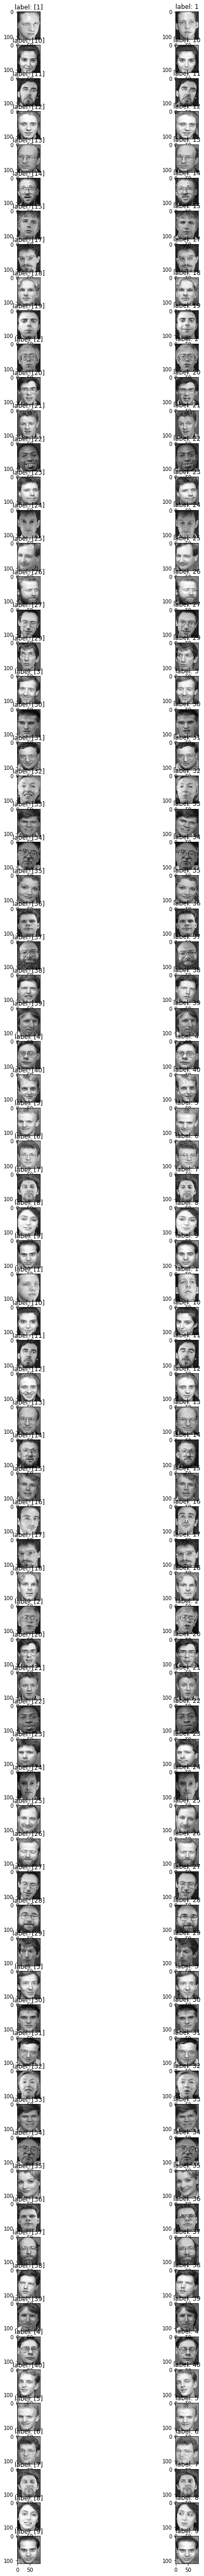

In [1015]:
#demonstration how model can identify emploee
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,show_correct=True)

In [1016]:
#Test block
# make shuffle for train dataset and define accuracy
index_shuffle=np.arange(train_set.shape[0])
np.random.shuffle(index_shuffle)
model_face_recognition(train_set,train_labels,train_set[index_shuffle],train_labels[index_shuffle],show_err=False)

Accuracy for test dataset = 100.0


100.0

## Optimization / Normalization steps

In [1017]:
#subtract mean value from the feature
def subtract_mean(x,axis=0):
    """
    Data normalizatin: x-x.mean
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    return x-x.mean(axis=axis,keepdims=True)

# standard score: (X-mu)/sigma
def standard_norm(X,axis=0):
    """
    Data normalizatin: (x-x.mean)/s.std
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    A=(X-X.mean(axis=axis, keepdims=True))/X.std( axis=axis, keepdims=True)
    return A

Normalization by features
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

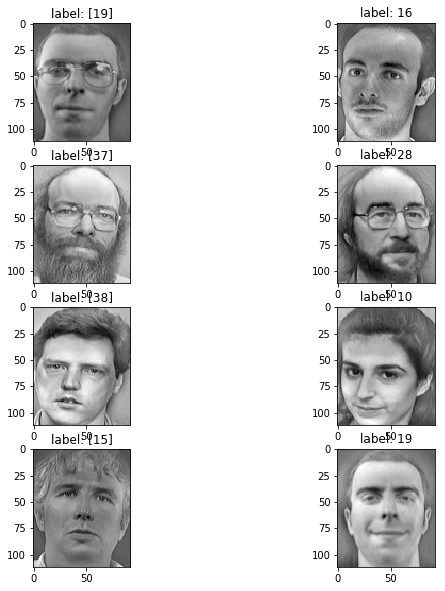

In [1018]:
# Accuracy for normalized dataset, method - subtract_mean
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True,norm=1,axis=0)

Normalization by samples
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

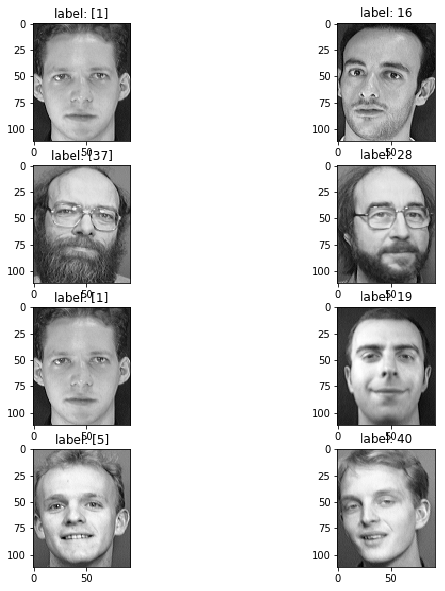

In [1019]:
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True,norm=1,axis=1)

In [23]:
#Accuracy didn't change, after normalization through subtraction mean from each feature

Normalization by features
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

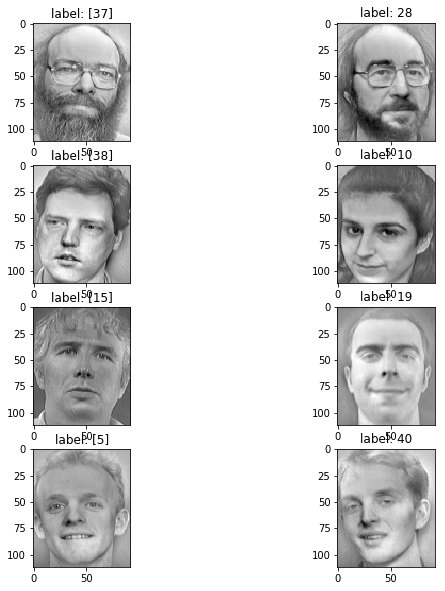

In [1020]:
# Accuracy for normalized dataset, method - standard score: (X-mu)/sigma
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True,norm=2,axis=0)

Normalization by samples
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

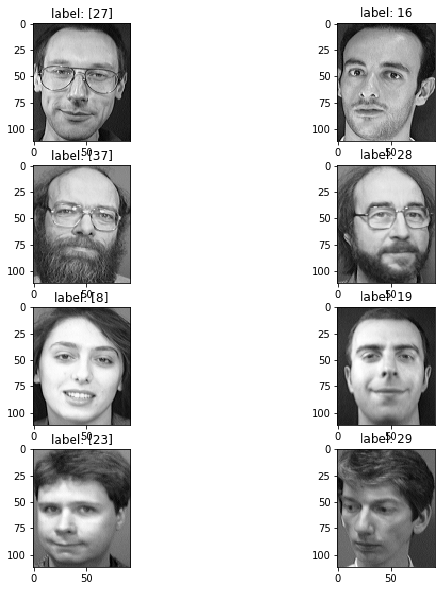

In [1021]:
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True,norm=2,axis=1)

In [26]:
# Accuracy didn't change after applying standardization of dataset

### Table of different types normalization and corresponding accuracy
| Accuracy | subtract_mean | standard_norm |
| --- | --- | --- |
| by features | 95 | 95 |
| by samples | 95 | 95 |

## PCA

In [1022]:
def my_pca(X,pca_energy=0.98,log=False):
    """
    My own realization pca model.
    Arguments:
    X -- Dataset
    pca_energy -- If float - explained variance, for example 0.98. If int and > 1, number of komponents. If 1 - all komponents are saved
    log -- turn on print log
    Returns:
    X_pca -- matrix after decomposition
    transform_pca -- matrix for decomposition test_set
    
    """
    #buid covariance matrix
    C=np.dot(X,X.T)
    #find out eigenvalues and eigen vectors
    eig, eig_v= np.linalg.eig(C)
    # choose type of pca model: use percent of variance or number of components
    if (type(pca_energy)==float or type(pca_energy)==np.float64) and (pca_energy<1):
        n=X.shape[1]
        p=1
        i=0
        while p>pca_energy:
            i+=1
            ind=np.argsort(-eig)[:n-i]
            p=np.sum(eig[ind])/np.sum(eig)
        important_vec=eig_v[ind]  
    elif pca_energy==1:
        important_vec=eig_v 
    else:
        ind_big=np.argsort(-eig)[:int(pca_energy)]
        important_vec=eig_v[ind_big]

    W=np.dot(important_vec,X)
    #Projecting all training samples into the PCA subspace.
    X_pca=np.dot(W,X.T)
    if log:
        print(f'pca_energy={pca_energy}, the number of components={X_pca.T.shape[1]}')
        print(f'shape train dataset after projection into PCA subspace {X_pca.T.shape}')  
    return X_pca.T,W

In [1023]:
#Normalization 'substract mean' by features
print("Normalization 'substract mean' by features")
for pca_energy in [0.95, 0.98, 0.99]:
    acc=model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=1, axis=0,
                           pca_flag=True, pca_energy=pca_energy)
    print(f'\n')

Normalization 'substract mean' by features
pca_energy=0.95, the number of components=160
shape train dataset after projection into PCA subspace (320, 160)
Accuracy for test dataset = 95.0


pca_energy=0.98, the number of components=228
shape train dataset after projection into PCA subspace (320, 228)
Accuracy for test dataset = 93.75


pca_energy=0.99, the number of components=263
shape train dataset after projection into PCA subspace (320, 263)
Accuracy for test dataset = 91.25




### Table accuracy for  different values of pca_energy (normalization by features, type 'subtract mean')
| pca_energy | number of components | accuracy |
| --- | --- | --- |
| 0.99 | 263 | 91.25 |
| 0.98 | 228 | 93.75 |
| 0.95 | 160 | 95 |

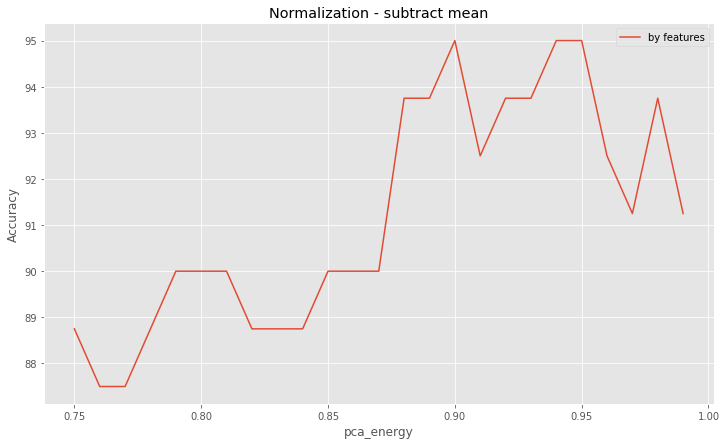

In [1024]:
#Vizualization
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
pca_list=np.arange(0.75,1,0.01)
results=[]
for p in pca_list:
    acc=model_face_recognition(train_set,train_labels,test_set,test_labels,
        show_err=False,show_correct=False, norm=1, axis=0, pca_flag=True, pca_energy=p,log=False)
    
    results.append(acc)
plt.plot(pca_list,results,label=f'by features')
plt.title(f'Normalization - subtract mean')
plt.xlabel('pca_energy')
plt.ylabel('Accuracy')
plt.grid(1)
plt.legend()

One of the most important applications of PCA is for speeding up machine learning algorithms.In this case 98% of the variance amount to 228 principal components.
Accuracy don't emprove and equal 93.75%

### LBP (Local Binary Pattern)

In [1025]:
#let's change euclide distanse for chi square distance
def identify_employee_chi(train_set,unknown_set):
    """
    This method use chi-square algorithm and identify employee.
    
    Arguments:
    train_set -- train dataset
    unknown_set -- vectorized photos that we have to recognize (test data set)
    
    Returns:
    predict_index -- vector of indices, that predict labels of test dataset images
    """
    min_dist=[]
    for ind in range(unknown_set.shape[0]):
        dist=chi_dist(unknown_set[ind,:], train_set)
        min_dist.append(np.argmin(dist))
    predict_index=np.array(min_dist).reshape(len(min_dist),1)
    return predict_index

In [1026]:
def chi_dist(f_obs, f_expect):
    """
    This method calculate chi-square distance.
    Arguments:
    f_obs -- observed frequency
    f_expect -- expected frequency
    
    Return:
    chi_value -- value of chi_square statistic
    """
    df=f_expect.shape[1]-1
    chi_value=np.sum((f_expect-f_obs)**2/df,axis=1,keepdims=True)
    #p_values=stats.chi2.cdf(p_arr,df)
    return chi_value

In [1027]:
#splitting images
def split_img(img,n,log=False):
    """
    Split image into n parts
    
    Arguments:
    img -- image
    n -- tne numper of parts for cutting
    log -- show result of cutting (if log=True)
    
    Return:
    M -- list of image parts
    """
    step_row=img.shape[0]//n
    step_col=img.shape[1]//n
    start_row=0
    start_col=0
    end_row=start_row+step_row
    end_col=start_col+step_col
    M=[]
    for i in range(n):
        start_col=0
        end_col=start_col+step_col
        for j in range(n):
            M.append(img[start_row:end_row,start_col:end_col])
            start_col=end_col
            end_col+=step_col
        start_row=end_row
        end_row+=step_row
    if log:
        print(f'Split parametr {n}*{n} ')
        ind=1
        for i in M:
            plt.subplot(n,n,ind)
            plt.imshow(i)
            ind+=1
    return M

Split parametr 4*4 


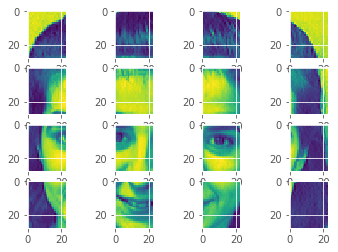

In [1028]:
M=split_img(img,n=4,log=True)

In [1030]:
#There are methods for interpolate pixels, when interpolation flag = True.
#Interpolation is high computational cost operation
def interplote_points(arr,R):
    """
    Calculate and return interpolate object.
    Arguments:
    arr - square array are used for calculation interpolation points inside this grid
    R -- radius, LBP parametr
    Return:
    f -- interpolate object
    """
    x=np.arange(-R,R+1,1)
    y=np.arange(-R,R+1,1)*(-1)
    f=interpolate.interp2d(x,y,arr)
    return f

#circularly symmetric neighborhood
def lbp_ext_points(R):
    """
    Circularly symmetric neighborhood for variable neighborhood sizes.
    Argument:
    R -- radius of circularly symmetric neighborhood
    Return:
    (x,y) -- coordinats of circularly symmetric neighborhood
    """
    N=R*8
    x=np.array([R*np.cos(2*np.pi*p/N) for p in range(1,N+1)])
    y=np.array([-R*np.sin(2*np.pi*p/N) for p in range(1,N+1)])
    return (x,y)

#Return vector of interpolate values, that corespond points from circularly symmetric neighborhood
def lbp_ext_neighbors(arr,R,points):
    """
    Return vector of interpolate values, that corespond points from circularly symmetric neighborhood.
    Arguments:
    arr - square array are used for calculation interpolation points inside this grid
    R -- radius, LBP parametr
    
    Return:
    interp_value - vector of interpolate values, that corespond points from circularly symmetric neighborhood
    """
    ff=interplote_points(arr,R)
    N=R*8
    x=points[0]
    y=points[1]
    interp_value=np.array([ff(x[ind],y[ind]) for ind in range (N) ])
    return interp_value

In [1035]:
def squre_pattern(ar):
    """
    Calculate surrounding pixels on square insted of circularly symmetric neighborhood.
    This operation is more quickly than interpolation.
    Argument:
    ar -- square array
    Return:
    res -- vector of intensity surrounding pixels
    """
    a1=ar[0,:]
    a2=ar[1:,-1]
    a3=ar[-1,:-1][::-1]
    a4=ar[1:-1,0][::-1]
    res=np.concatenate((a1,a2,a3,a4))
    return res

def calc_pattern_2(M,R,ind,points, interpolation):
    """
     Taking the R*8 bit binary neighborhood of the center pixel and converting it into a decimal representation.
     
     Arguments:
     M -- 2D array of image
     R -- The radius of the circle, which allows us to account for different scales
     ind -- indices (row, column) of centrer pixel
     points -- coordinats of circularly symmetric neighborhood
     interpolation -- turn on (True) / off (False) interpolation
    
     Return:
     lbp - decimal representation of local binear pattern
    """
    r=ind[0]
    c=ind[1]
    center=M[r,c]
    #ДЕлаем квадратный массив sq_arr на основании R & center
    row_start=r-R
    col_start=c-R
    row_end=r+R
    col_end=c+R
    sq_arr=M[row_start:row_end+1,col_start:col_end+1]
    if interpolation:
        neighborhood=lbp_ext_neighbors(sq_arr,R,points)
    else:
        neighborhood=squre_pattern(sq_arr)    
    lbp=0
    for i in enumerate(neighborhood):
        if center>i[1]:
            lbp+=2**i[0]
    return lbp 

def lbt_transform_2(im,R,points,interpolation): 
    """
    Apply lbp_transformation to image
    
    Argument:
    im -- 2D array of image
    R -- The radius of the circle, which allows us to account for different scales
    points -- coordinats of circularly symmetric neighborhood
    interpolation -- turn on (True) / off (False) interpolation
    
    Return 2D array of transformed image
    """
    rows=im.shape[0]
    columns=im.shape[1]
    res=np.zeros((rows-2*R,columns-2*R))
    for r in range(R,rows-R):
        for c in range(R,columns-R):
            pattern=calc_pattern_2(im,R,(r,c),points,interpolation)
            res[r-R,c-R]=pattern
    return res

def create_lbp_set_2(data,R,n_split=1,height=HEIGHT,width=WIDTH,interpolation=False):
    """
    Apply LBP transformation for all images in dataset
    
    Arguments:
    data -- Matrix of dataset
    R -- The radius of the circle, which allows us to account for different scales
    n_split -- the number of blocks(divide the images into n*n blocks)
    height -- height of image in pixels, default value = 112
    width -- width of image, default value - 92
    interpolation -- turn on (True) / off (False) interpolation
    
    Return:
    result -- Matrix of dataset after applying LBT-transformation
    
    """
    row=0
    data_lbp_split=[]
    points=lbp_ext_points(R)
    neighbors=R*8
    features=(neighbors*(neighbors-1)+2)+1
    for f in data:
        if n_split==1:
            feature_part=lbt_transform_2(f.reshape(HEIGHT,WIDTH),R,points,interpolation).ravel()
            hist_sample=np.histogram(feature_part,bins=features)
            data_lbp_split.append(hist_sample[0])       
        else:
            M=split_img(f.reshape(HEIGHT,WIDTH),n=n_split)
            feature_all=np.array([])
            for part in M:
                feature_part=lbt_transform_2(part,R,points,interpolation).ravel()
                hist_sample=np.histogram(feature_part,bins=features)
                feature_all=np.concatenate((feature_all,hist_sample[0]))
            data_lbp_split.append(feature_all)
    result=np.array(data_lbp_split)
    return result

Wall time: 175 ms
Wall time: 4.62 s


Text(0.5, 1.0, 'interpolation')

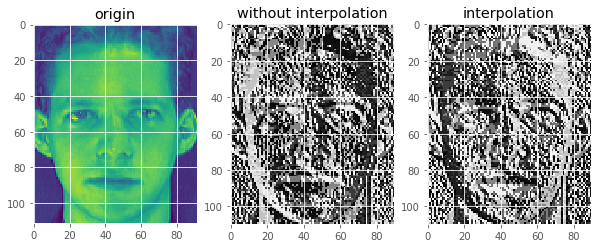

In [1036]:
#test block
R=1
points=lbp_ext_points(R)
%time tt=lbt_transform_2(img_arr,R,points,interpolation=False)
%time tt_interp=lbt_transform_2(img_arr,R,points,interpolation=True)
im_v=train_set[0]
img_arr=im_v.reshape(112,92)
plt.figure(figsize=(10,7))
plt.subplot(131)
plt.imshow(img_arr)
plt.title('origin')
plt.subplot(1,3,2)
plt.imshow(tt,cmap='gray')
plt.title('without interpolation')
plt.subplot(1,3,3)
plt.imshow(tt_interp,cmap='gray')
plt.title('interpolation')

For LBT algorithm use only standardize data by samples (norm=2,axis=1)
Accuracy for test dataset = 97.5
Predict photo                          Real photo


97.5

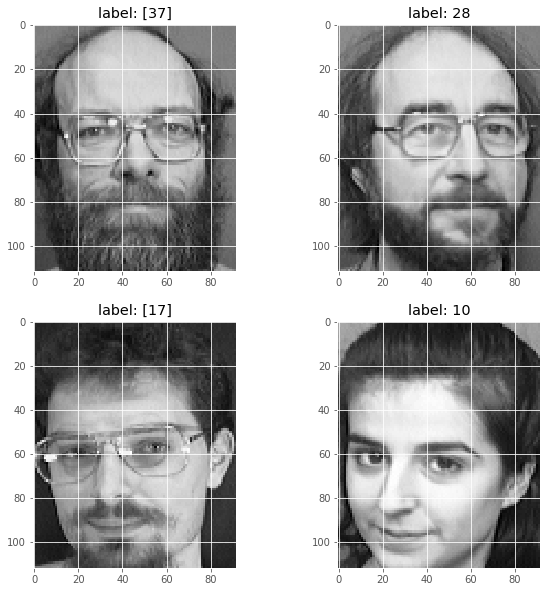

In [1038]:
# Main model with LBT parameters
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=True,show_correct=False,figsize=(10,10), index=3, norm=2, axis=1,
                           pca_flag=False, pca_energy=0.98,log=True, lbp_flag=True,n_split=3,R=3,interpolation=False)

In [933]:
%%time
#Test the combinations of (N,R). N=1,2,3...8, R=1,2...4
N_list=np.arange(1,9,1)
R_list=np.arange(1,5,1)
acc_score=[]
all_results=[]
for n in N_list:
    for r in R_list:
        train_=create_lbp_set_2(train_set,R=r,n_split=n,interpolation=False)
        test_=create_lbp_set_2(test_set,R=r,n_split=n,interpolation=False)
        predict_index=identify_employee_chi(standard_norm(train_,axis=1),standard_norm(test_,axis=1))
        acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
        print (f'train_ {train_.shape}, acc={acc}, N={n}, R={r}')
        acc_score.append(acc)
        all_results.append([n,r,acc,train_.shape[1]])

train_ (320, 59), acc=83.75, N=1, R=1
train_ (320, 243), acc=91.25, N=1, R=2
train_ (320, 555), acc=83.75, N=1, R=3
train_ (320, 995), acc=82.5, N=1, R=4
train_ (320, 236), acc=96.25, N=2, R=1
train_ (320, 972), acc=93.75, N=2, R=2
train_ (320, 2220), acc=95.0, N=2, R=3
train_ (320, 3980), acc=90.0, N=2, R=4
train_ (320, 531), acc=96.25, N=3, R=1
train_ (320, 2187), acc=96.25, N=3, R=2
train_ (320, 4995), acc=97.5, N=3, R=3
train_ (320, 8955), acc=96.25, N=3, R=4
train_ (320, 944), acc=97.5, N=4, R=1
train_ (320, 3888), acc=96.25, N=4, R=2
train_ (320, 8880), acc=95.0, N=4, R=3
train_ (320, 15920), acc=92.5, N=4, R=4
train_ (320, 1475), acc=95.0, N=5, R=1
train_ (320, 6075), acc=95.0, N=5, R=2
train_ (320, 13875), acc=87.5, N=5, R=3
train_ (320, 24875), acc=83.75, N=5, R=4
train_ (320, 2124), acc=93.75, N=6, R=1
train_ (320, 8748), acc=88.75, N=6, R=2
train_ (320, 19980), acc=85.0, N=6, R=3
train_ (320, 35820), acc=78.75, N=6, R=4
train_ (320, 2891), acc=92.5, N=7, R=1
train_ (320, 119

In [ ]:
#LBT with interpolation surrounding neighborhood

In [934]:
%%time
#Accuracy for LBT parameters(N=4,R=1) with interpolation surrounding neighborhood
n=3
r=3
train_interp=create_lbp_set_2(train_set,R=r,n_split=n,interpolation=True)
test_interp=create_lbp_set_2(test_set,R=r,n_split=n,interpolation=True)

Wall time: 49min 19s


In [935]:
#np.save('train_interp_33',train_interp)
#np.save('test_interp_33',test_interp)

In [938]:
predict_index=identify_employee_chi(standard_norm(train_interp,axis=1),standard_norm(test_interp,axis=1))
acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
print(f'#Accuracy = {acc} for LBT parameters(N={n},R={r}) with interpolation surrounding neighborhood')

#Accuracy = 97.5 for LBT parameters(N=3,R=3) with interpolation surrounding neighborhood


In [ ]:
%%time
#Accuracy for LBT parameters(N=4,R=1) with interpolation surrounding neighborhood
n=4
r=1
train_interp_41=create_lbp_set_2(train_set,R=r,n_split=n,interpolation=True)
test_interp_41=create_lbp_set_2(test_set,R=r,n_split=n,interpolation=True)

In [944]:
#np.save('train_interp_41',train_interp_41)
#np.save('test_interp_41',test_interp_41)

In [943]:
predict_index=identify_employee_chi(standard_norm(train_interp_41,axis=1),standard_norm(test_interp_41,axis=1))
acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
print(f'#Accuracy = {acc} for LBT parameters(N={n},R={r}) with interpolation surrounding neighborhood')

#Accuracy = 98.75 for LBT parameters(N=4,R=1) with interpolation surrounding neighborhood


In [968]:
%%time
# PCA + LBT
#Test block. LBT + PCA with parameters R=3, n_split=3, pca_energy=0.98. Expected accuracy = 97.5
R=3
n_split=3
pca_energy=0.98

train_lbp2_split=create_lbp_set_2(train_set,R,n_split,interpolation=False)
test_lbp2_split=create_lbp_set_2(test_set,R,n_split,interpolation=False)
print (f'train_lbp2_split {train_lbp2_split.shape}')
print (f'test_lbp2_split {test_lbp2_split.shape}')
predict_index=identify_employee_chi(standard_norm(train_lbp2_split,axis=1),standard_norm(test_lbp2_split,axis=1))
acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
print(acc)

train_lbp2_split (320, 4995)
test_lbp2_split (80, 4995)
97.5
Wall time: 1min 16s


In [979]:
#PCA aftre LBP N=3, R=3
pca_list=[0.95,0.98,0.99]
pca_lbp_scores=[]
for pca_energy in pca_list:
    train_lbp_pca,transform_pca=my_pca(train_lbp2_split,pca_energy)
    test_lbp_pca=np.dot(transform_pca,test_lbp2_split.T).T
    predict_index=identify_employee_chi(standard_norm(train_lbp_pca,axis=1),standard_norm(test_lbp_pca,axis=1))
    acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
    pca_lbp_scores.append([acc,train_lbp_pca.shape[1],pca_energy])
    print(f'Accuracy after pca implementation {acc}, features= {train_lbp_pca.shape[1]}, pca_energy= {pca_energy}')

Accuracy after pca implementation 87.5, features= 13, pca_energy= 0.95
Accuracy after pca implementation 91.25, features= 37, pca_energy= 0.98
Accuracy after pca implementation 93.75, features= 71, pca_energy= 0.99


In [985]:
R=1
n_split=4
pca_energy=0.98
train_lbp41_split=create_lbp_set_2(train_set,R,n_split,interpolation=False)
test_lbp41_split=create_lbp_set_2(test_set,R,n_split,interpolation=False)
predict_index=identify_employee_chi(standard_norm(train_lbp41_split,axis=1),standard_norm(test_lbp41_split,axis=1))
acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
print(f'accuracy {acc} for parameters n_split={n_split}, R={R}, shape dataset {train_lbp41_split.shape}')

accuracy 97.5 for parameters n_split=4, R=1, shape dataset (320, 944)


In [986]:
#PCA aftre LBP N=4, R=1
pca_list=[0.95,0.98,0.99]
pca_lbp_scores41=[]
for pca_energy in pca_list:
    train_lbp_pca,transform_pca=my_pca(train_lbp41_split,pca_energy)
    test_lbp_pca=np.dot(transform_pca,test_lbp41_split.T).T
    predict_index=identify_employee_chi(standard_norm(train_lbp_pca,axis=1),standard_norm(test_lbp_pca,axis=1))
    acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
    pca_lbp_scores41.append([acc,train_lbp_pca.shape[1],pca_energy])
    print(f'Accuracy after pca implementation {acc}, features= {train_lbp_pca.shape[1]}, pca_energy= {pca_energy}')

Accuracy after pca implementation 85.0, features= 21, pca_energy= 0.95
Accuracy after pca implementation 88.75, features= 68, pca_energy= 0.98
Accuracy after pca implementation 83.75, features= 121, pca_energy= 0.99


In [997]:
#main model with PCA and LBP parameters
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=2, axis=1,
                           pca_flag=True, pca_energy=0.99,log=True, lbp_flag=True,n_split=3,R=3,interpolation=False)

pca_energy=0.99, the number of components=71
shape train dataset after projection into PCA subspace (320, 71)
For LBT algorithm use only standardize data by samples (norm=2,axis=1)
Accuracy for test dataset = 93.75


93.75

In [998]:
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=2, axis=1,
                           pca_flag=True, pca_energy=0.98,log=True, lbp_flag=True,n_split=n,R=r,interpolation=False)

pca_energy=0.98, the number of components=68
shape train dataset after projection into PCA subspace (320, 68)
For LBT algorithm use only standardize data by samples (norm=2,axis=1)
Accuracy for test dataset = 88.75


88.75

I we use LBP (N=3, R=3) and PCA (pca_energy=0.98) together, we get accuracy = 93.75 and reduce features to 71

## END 8-)

## aditional methods

In [145]:

def total_hist(X,labels):
    """
    This method make histogram for each class (10 images) and measure chi_square distance from test sample to each histogram
    
    Arguments:
    X -- original matrix (dataset)
    labels -- labels for samples from original dataset
    
    Returns:
    X_hist -- dataset after transformation
    lh -- labels for X_hist dataset
    """
    lh=[]
    hist_union=np.zeros((40,columns*8))
    row=0
    for ind in range(0,320,8):
        c=X[ind]
        for i in range(1,8,1):
            c=np.concatenate((c,X[ind+i])) 
        hist_union[row,:]=c
        lh.append(labels[ind])
        row+=1
    X_hist=hist_lbp_features(hist_union)
    #hist_labels=np.arange(1,41,1)
    print(f'total hist shape{X_hist.shape}')
    return  X_hist, np.array(lh)   

In [146]:
X_hist, lh = total_hist(train_lbp,train_labels_lbp)

total hist shape(40, 59)


In [165]:
predict_index=identify_employee_chi(standard_norm(X_hist,axis=0),standard_norm(test_hist,axis=0))
acc=(np.sum(np.squeeze(lh[predict_index])==np.squeeze(test_labels_lbp))/80)*100
acc

73.75

In [1029]:
def square_array(M,R,ind):
    """"
    Make square array. 
    Arguments:
    M -- raw array
    R -- radius (length of square edge = R+1+R)
    ind --- (x,y) coordinates of center square array
    Return:
    sq_arr -- square array from raw array
    """
    r=ind[0]
    c=ind[1]
    center=M[r,c]
    row_start=r-R
    col_start=c-R
    row_end=r+R
    col_end=c+R
    sq_arr=M[row_start:row_end+1,col_start:col_end+1]
    return sq_arr

In [954]:
%%time
#Test block. LBT algorithm with parameters R=3, n_split=3. Expected accuracy = 97.5
R=3
n_split=3
train_lbp2_split=create_lbp_set_2(train_set,R,n_split,interpolation=False)
test_lbp2_split=create_lbp_set_2(test_set,R,n_split,interpolation=False)
print (f'train_lbp2_split {train_lbp2_split.shape}')
print (f'test_lbp2_split {test_lbp2_split.shape}')
predict_index=identify_employee_chi(standard_norm(train_lbp2_split,axis=1),standard_norm(test_lbp2_split,axis=1))
acc,_,_=accuracy(train_labels_lbp,test_labels_lbp, predict_index)
print(acc)

train_lbp2_split (320, 4995)
test_lbp2_split (80, 4995)
97.5
Wall time: 1min 14s
